# Import dependencies

In [120]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import PC, MaximumLikelihoodEstimator

# Load data and preprocess


In [106]:
DATA_PATH = "US_Crime_DataSet.csv"

columns = [
    "Victim Sex",
    "Victim Age",
    "Victim Race",
    "Perpetrator Sex",
    "Perpetrator Age",
    "Perpetrator Race",
    "Relationship",
    "Weapon",
]

df = pd.read_csv(DATA_PATH, dtype={"Perpetrator Age": str})[columns]


# Delete rows with NaNs and 'Unknown' values
for col in columns:
    df = df[df[col] != "Unknown"]

df = df[df["Victim Age"] < 100]  # Delete rows with unexpected values


df["Perpetrator Age"] = pd.to_numeric(df["Perpetrator Age"], errors="coerce")  # Convert to numeric, set NaNs for non-numeric values
df = df.dropna(subset=["Perpetrator Age"])  # Delete NaNs in "Perpetrator Age"
df["Perpetrator Age"] = df["Perpetrator Age"].astype(int)
df = df[df["Perpetrator Age"] > 0]

# Learn the model structure using PC algorithm

In [ ]:
est = PC(data=df)
estimated_model = est.estimate(variant="parallel", max_cond_vars=6, ci_test="log_likelihood")

Working for n conditional variables: 6: 100%|██████████| 6/6 [01:55<00:00, 19.30s/it]


In [5]:
str(estimated_model)

'DAG with 8 nodes and 10 edges'

In [109]:
estimated_model.edges()

OutEdgeView([('Victim Age', 'Victim Sex'), ('Relationship', 'Victim Sex'), ('Relationship', 'Perpetrator Sex'), ('Relationship', 'Perpetrator Race'), ('Relationship', 'Victim Race'), ('Weapon', 'Victim Race'), ('Weapon', 'Perpetrator Sex'), ('Victim Race', 'Perpetrator Race'), ('Victim Race', 'Perpetrator Sex'), ('Perpetrator Race', 'Perpetrator Sex')])

In [111]:
murders_model = BayesianNetwork(
    [
        ("Relationship", "Perpetrator Race"),
        ("Relationship", "Perpetrator Sex"),
        ("Relationship", "Victim Race"),
        ("Relationship", "Victim Sex"),
        ("Perpetrator Race", "Perpetrator Sex"),
        ("Victim Race", "Perpetrator Sex"),
        ("Victim Race", "Perpetrator Race"),
        ("Victim Age", "Victim Sex"),
        ("Weapon", "Perpetrator Sex"),
        ("Weapon", "Victim Race"),
    ]
)
murders_model.add_node("Perpetrator Age")

# Using the Maximumum Likelihood Estimator for CPDs

In [112]:
# Initialize the estimator object.
mle_est = MaximumLikelihoodEstimator(model=murders_model, data=df)

# Estimate all the CPDs
all_cpds = mle_est.get_parameters(n_jobs=1)

# Add the estimated CPDs to the model.
murders_model.add_cpds(*all_cpds)

cpds = murders_model.get_cpds()
cpds

[<TabularCPD representing P(Relationship:27) at 0x1df8b08e810>,
 <TabularCPD representing P(Perpetrator Race:4 | Relationship:27, Victim Race:4) at 0x1df8b08e0c0>,
 <TabularCPD representing P(Perpetrator Sex:2 | Perpetrator Race:4, Relationship:27, Victim Race:4, Weapon:15) at 0x1df8b08e1e0>,
 <TabularCPD representing P(Victim Race:4 | Relationship:27, Weapon:15) at 0x1df8b08cbc0>,
 <TabularCPD representing P(Victim Sex:2 | Relationship:27, Victim Age:100) at 0x1df8b08c9b0>,
 <TabularCPD representing P(Victim Age:100) at 0x1df8b08dcd0>,
 <TabularCPD representing P(Weapon:15) at 0x1df8b08d7f0>,
 <TabularCPD representing P(Perpetrator Age:99) at 0x1df8b08eb40>]

In [114]:
murders_model.check_model()

True

# Examples of CPDs

In [115]:
cpd = murders_model.get_cpds("Perpetrator Sex")

cpd.to_csv("Perpetrator_Sex.csv")
df_ps = pd.read_csv("Perpetrator_Sex.csv", header=None)
df_ps


,0,1,2,3,4,5,6,7,8,9,...,6471,6472,6473,6474,6475,6476,6477,6478,6479,6480
0,Perpetrator Race,Perpetrator Race(Asian/Pacific Islander),Perpetrator Race(Asian/Pacific Islander),Perpetrator Race(Asian/Pacific Islander),Perpetrator Race(Asian/Pacific Islander),Perpetrator Race(Asian/Pacific Islander),Perpetrator Race(Asian/Pacific Islander),Perpetrator Race(Asian/Pacific Islander),Perpetrator Race(Asian/Pacific Islander),Perpetrator Race(Asian/Pacific Islander),...,Perpetrator Race(White),Perpetrator Race(White),Perpetrator Race(White),Perpetrator Race(White),Perpetrator Race(White),Perpetrator Race(White),Perpetrator Race(White),Perpetrator Race(White),Perpetrator Race(White),Perpetrator Race(White)
1,Relationship,Relationship(Acquaintance),Relationship(Acquaintance),Relationship(Acquaintance),Relationship(Acquaintance),Relationship(Acquaintance),Relationship(Acquaintance),Relationship(Acquaintance),Relationship(Acquaintance),Relationship(Acquaintance),...,Relationship(Wife),Relationship(Wife),Relationship(Wife),Relationship(Wife),Relationship(Wife),Relationship(Wife),Relationship(Wife),Relationship(Wife),Relationship(Wife),Relationship(Wife)
2,Victim Race,Victim Race(Asian/Pacific Islander),Victim Race(Asian/Pacific Islander),Victim Race(Asian/Pacific Islander),Victim Race(Asian/Pacific Islander),Victim Race(Asian/Pacific Islander),Victim Race(Asian/Pacific Islander),Victim Race(Asian/Pacific Islander),Victim Race(Asian/Pacific Islander),Victim Race(Asian/Pacific Islander),...,Victim Race(White),Victim Race(White),Victim Race(White),Victim Race(White),Victim Race(White),Victim Race(White),Victim Race(White),Victim Race(White),Victim Race(White),Victim Race(White)
3,Weapon,Weapon(Blunt Object),Weapon(Drowning),Weapon(Drugs),Weapon(Explosives),Weapon(Fall),Weapon(Fire),Weapon(Firearm),Weapon(Gun),Weapon(Handgun),...,Weapon(Fire),Weapon(Firearm),Weapon(Gun),Weapon(Handgun),Weapon(Knife),Weapon(Poison),Weapon(Rifle),Weapon(Shotgun),Weapon(Strangulation),Weapon(Suffocation)
4,Perpetrator Sex(Female),0.12345679012345678,0.0,0.5,0.5,0.5,0.23076923076923078,0.03225806451612903,0.0,0.018912529550827423,...,0.0,0.004070556309362279,0.0,0.0037593984962406013,0.0036997885835095136,0.0,0.0008802816901408451,0.0011661807580174927,0.005917159763313609,0.0
5,Perpetrator Sex(Male),0.8765432098765432,1.0,0.5,0.5,0.5,0.7692307692307693,0.967741935483871,1.0,0.9810874704491725,...,1.0,0.9959294436906377,1.0,0.9962406015037594,0.9963002114164905,1.0,0.9991197183098591,0.9988338192419826,0.9940828402366864,1.0


In [100]:
cpd = murders_model.get_cpds("Perpetrator Race")

cpd.to_csv("Perpetrator_Race.csv")
df_pr = pd.read_csv("Perpetrator_Race.csv", header=None)
df_pr

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
0,Relationship,Relationship(Acquaintance),Relationship(Acquaintance),Relationship(Acquaintance),Relationship(Acquaintance),Relationship(Boyfriend),Relationship(Boyfriend),Relationship(Boyfriend),Relationship(Boyfriend),Relationship(Boyfriend/Girlfriend),...,Relationship(Stepson),Relationship(Stepson),Relationship(Stranger),Relationship(Stranger),Relationship(Stranger),Relationship(Stranger),Relationship(Wife),Relationship(Wife),Relationship(Wife),Relationship(Wife)
1,Victim Race,Victim Race(Asian/Pacific Islander),Victim Race(Black),Victim Race(Native American/Alaska Native),Victim Race(White),Victim Race(Asian/Pacific Islander),Victim Race(Black),Victim Race(Native American/Alaska Native),Victim Race(White),Victim Race(Asian/Pacific Islander),...,Victim Race(Native American/Alaska Native),Victim Race(White),Victim Race(Asian/Pacific Islander),Victim Race(Black),Victim Race(Native American/Alaska Native),Victim Race(White),Victim Race(Asian/Pacific Islander),Victim Race(Black),Victim Race(Native American/Alaska Native),Victim Race(White)
2,Perpetrator Race(Asian/Pacific Islander),0.6652433817250214,0.0015589730265187808,0.005454545454545455,0.005251441292311205,0.675,0.0015273838097316168,0.0,0.008429458740017746,0.4,...,0.0,0.0044444444444444444,0.29394812680115273,0.008594856258438437,0.014059753954305799,0.011451952089238365,0.7446457990115322,0.00020597322348094748,0.006993006993006993,0.004420703628660895
3,Perpetrator Race(Black),0.11528608027327071,0.9420744084834115,0.08545454545454545,0.12255265711513214,0.05,0.9567968579533057,0.0,0.06743566992014197,0.1,...,0.0,0.04296296296296296,0.3515850144092219,0.7692890308558633,0.24428822495606328,0.26140623571363264,0.044481054365733116,0.9746652935118435,0.06993006993006994,0.031006324062135444
4,Perpetrator Race(Native American/Alaska Native),0.0025619128949615714,0.0010717939557316617,0.5618181818181818,0.008524078619403694,0.0,0.0026183722452542005,0.8,0.011978704525288377,0.0,...,0.75,0.005925925925925926,0.006340057636887608,0.0013172193499522509,0.18980667838312829,0.006971747279875652,0.0016474464579901153,0.0006179196704428424,0.6433566433566433,0.0015963651992386566
5,Perpetrator Race(White),0.21690862510674638,0.055294824534338004,0.3472727272727273,0.8636718229731529,0.275,0.039057385991708486,0.2,0.9121561668145519,0.5,...,0.25,0.9466666666666667,0.34812680115273775,0.22079889353574603,0.5518453427065027,0.7201700649172533,0.20922570016474465,0.02451081359423275,0.27972027972027974,0.962976607109965


In [123]:
cpd = murders_model.get_cpds("Weapon")

cpd.to_csv("Weapon.csv")

# Preprocessing for Weapon CPD
weapon_cpd = pd.read_csv("Weapon.csv", header=None, names=["Weapon", "Probability"])
weapon_cpd["Weapon"] = weapon_cpd["Weapon"].str.replace("Weapon\\(", "", regex=True).str.replace("\\)", "", regex=True)
weapon_cpd

,Weapon,Probability
0,Blunt Object,0.125333
1,Drowning,0.002791
2,Drugs,0.003560
3,Explosives,0.001022
4,Fall,0.000446
5,Fire,0.010299
6,Firearm,0.037141
7,Gun,0.002292
8,Handgun,0.489251
9,Knife,0.188366


In [122]:
victim_sex_cpd = murders_model.get_cpds("Victim Sex")

# Visualization of network

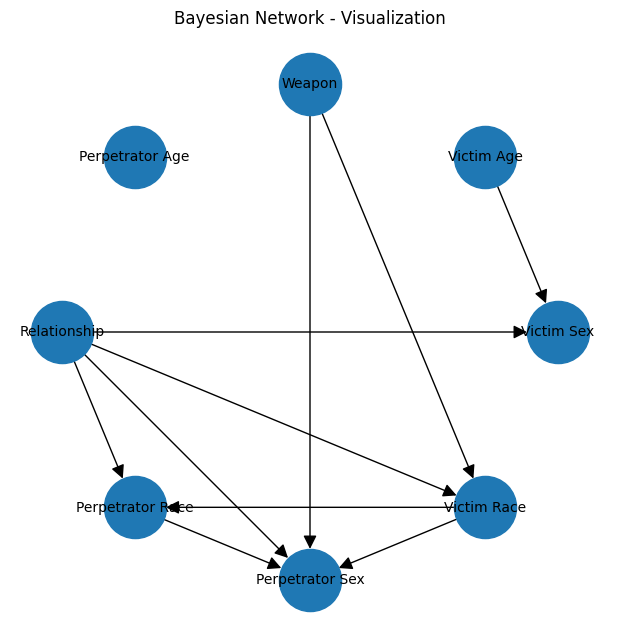

In [117]:
edges = murders_model.edges()
G = nx.DiGraph()
G.add_edges_from(edges)
G.add_node("Perpetrator Age") 

plt.figure(figsize=(6, 6))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, arrowsize=20)
plt.title("Bayesian Network - Visualization")
plt.show()